## Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility

In [2]:
def show_image(batch_of_tensors):
    images = batch_of_tensors[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

## Hyperparameters

In [3]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 50
latent_dim = 128
image_size = 32
channels = 3

## Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1 to 1]
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 40902308.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Variational Autoencoder Model

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten() # VAE flattens the encoded activation maps
        )

        # 4*4 comes from spatial resolution
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, latent_dim).to(device)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        constructed_images = self.decoder(z)
        return constructed_images

## Loss Function

This is a combination of reconstruction loss and the kl divergence between the posterior and the prior (which is a Unit Normal).

In [6]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

## Training

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/50: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s, Loss=2e+4]


Epoch [1/50] Average Loss: 348.2547


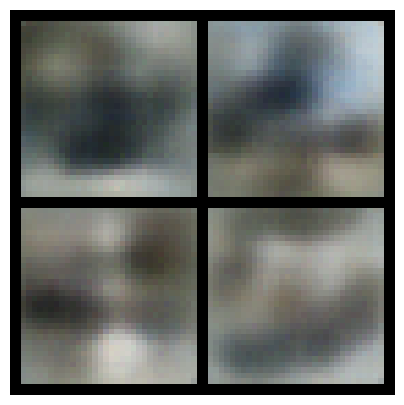

Epoch 2/50: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s, Loss=1.75e+4]


Epoch [2/50] Average Loss: 222.7771


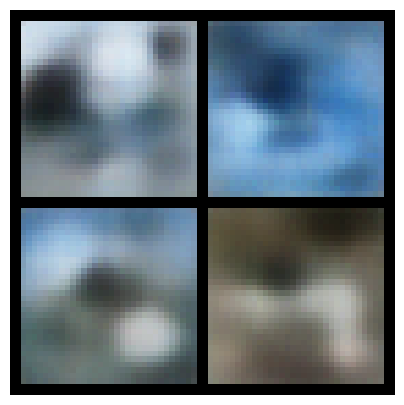

Epoch 3/50: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s, Loss=1.62e+4]


Epoch [3/50] Average Loss: 206.2572


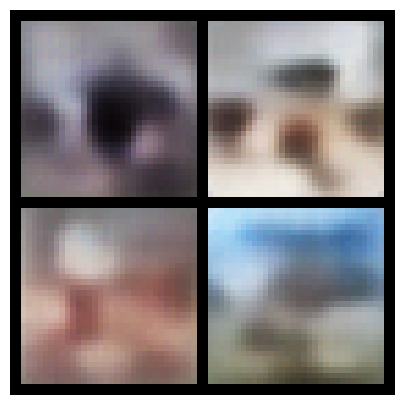

Epoch 4/50: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s, Loss=1.49e+4]


Epoch [4/50] Average Loss: 199.8050


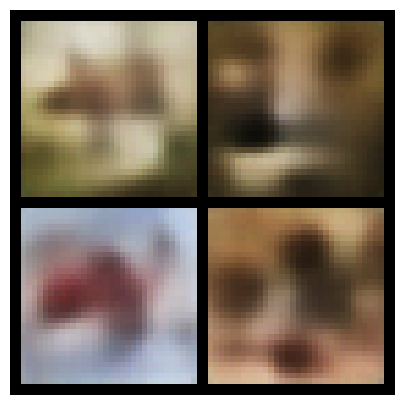

Epoch 5/50: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s, Loss=1.55e+4]


Epoch [5/50] Average Loss: 195.9575


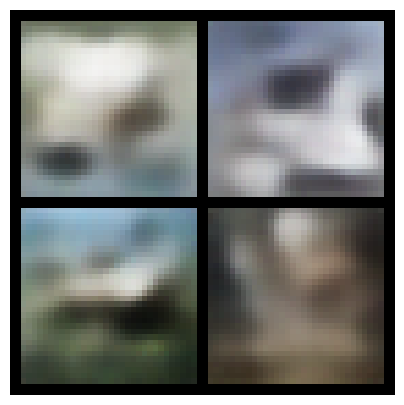

Epoch 6/50: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s, Loss=1.55e+4]


Epoch [6/50] Average Loss: 193.7126


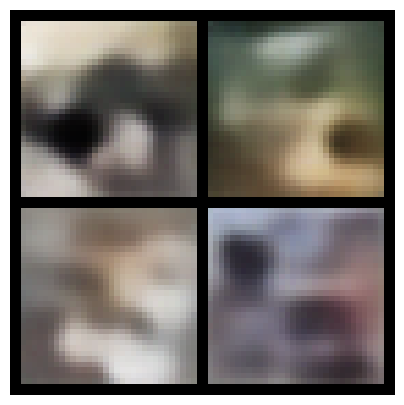

Epoch 7/50: 100%|██████████| 391/391 [00:21<00:00, 18.14it/s, Loss=1.49e+4]


Epoch [7/50] Average Loss: 192.1039


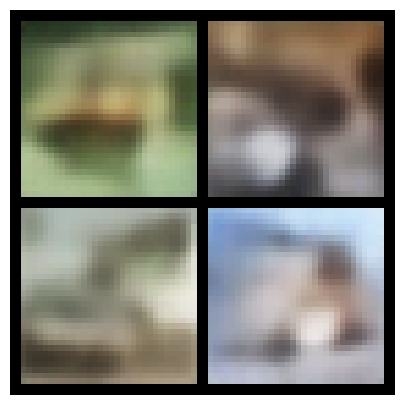

Epoch 8/50: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s, Loss=1.52e+4]


Epoch [8/50] Average Loss: 190.6227


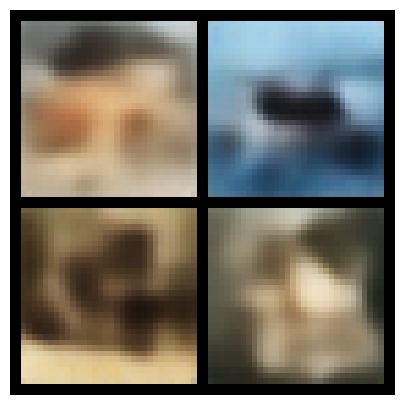

Epoch 9/50: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s, Loss=1.45e+4]


Epoch [9/50] Average Loss: 189.6621


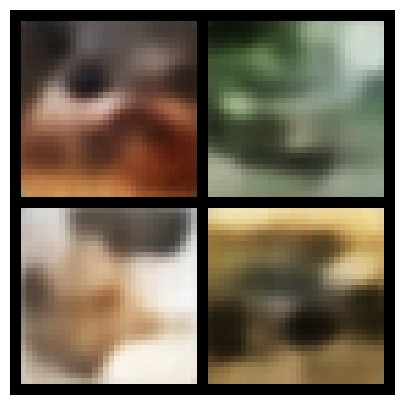

Epoch 10/50: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s, Loss=1.54e+4]


Epoch [10/50] Average Loss: 188.7772


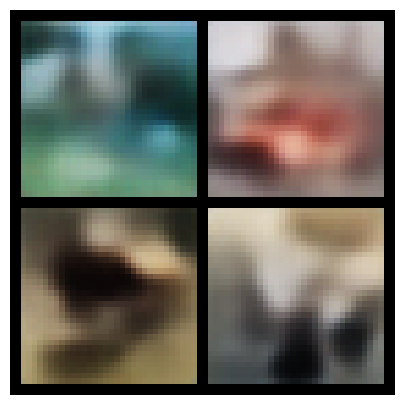

Epoch 11/50: 100%|██████████| 391/391 [00:21<00:00, 18.19it/s, Loss=1.47e+4]


Epoch [11/50] Average Loss: 188.1125


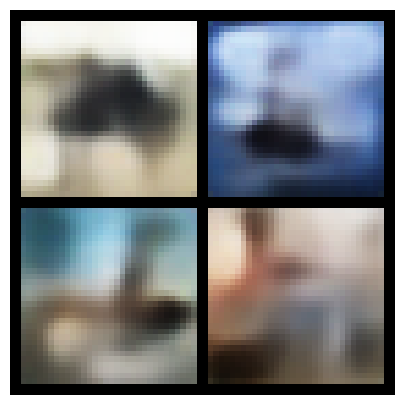

Epoch 12/50: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s, Loss=1.55e+4]


Epoch [12/50] Average Loss: 187.4055


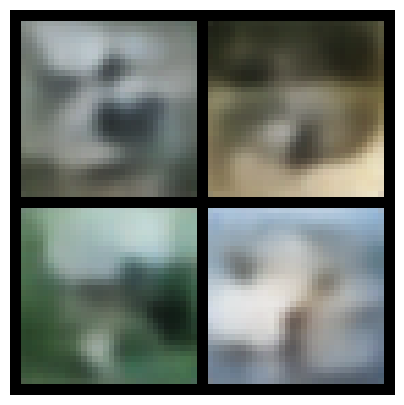

Epoch 13/50: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s, Loss=1.48e+4]


Epoch [13/50] Average Loss: 186.8648


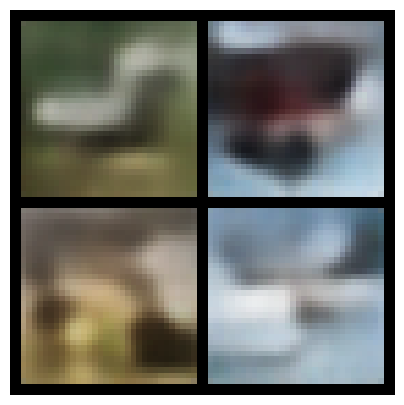

Epoch 14/50: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s, Loss=1.48e+4]


Epoch [14/50] Average Loss: 186.5419


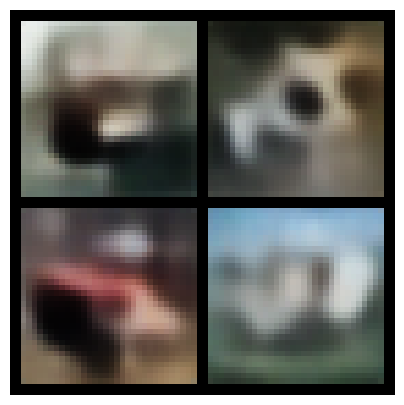

Epoch 15/50: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, Loss=1.44e+4]


Epoch [15/50] Average Loss: 186.0854


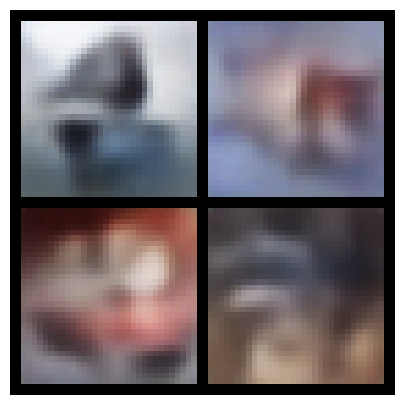

Epoch 16/50: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, Loss=1.5e+4]


Epoch [16/50] Average Loss: 185.6831


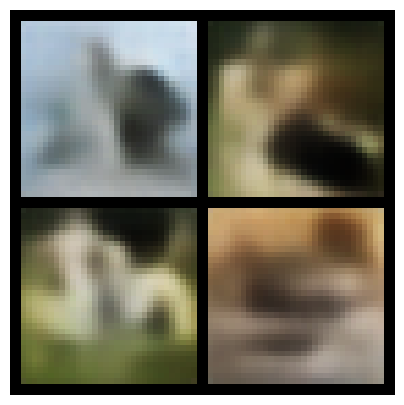

Epoch 17/50: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, Loss=1.51e+4]


Epoch [17/50] Average Loss: 185.3304


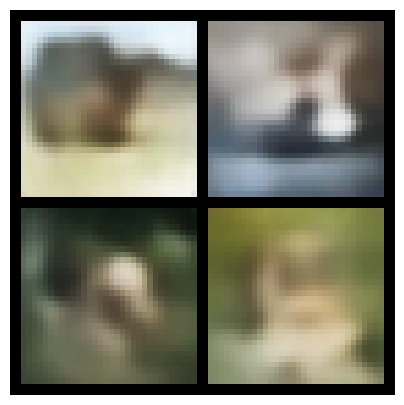

Epoch 18/50: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s, Loss=1.57e+4]


Epoch [18/50] Average Loss: 184.9097


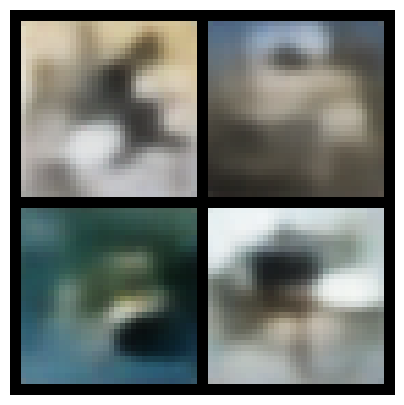

Epoch 19/50: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s, Loss=1.53e+4]

Epoch [19/50] Average Loss: 184.7743


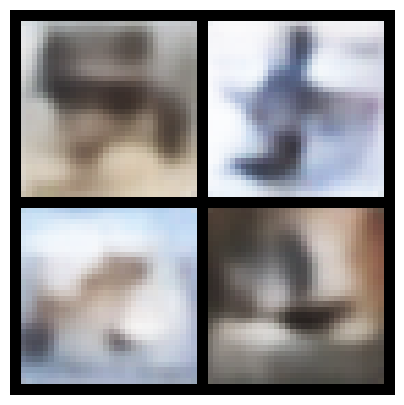

Epoch 20/50: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s, Loss=1.45e+4]


Epoch [20/50] Average Loss: 184.5005


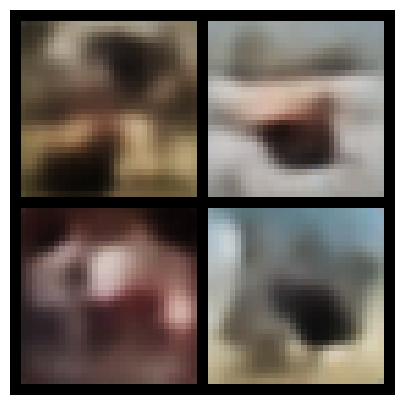

Epoch 21/50: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, Loss=1.48e+4]


Epoch [21/50] Average Loss: 184.3717


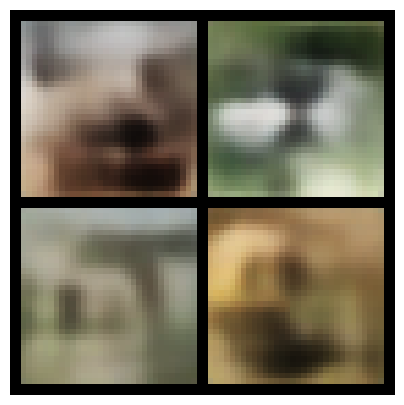

Epoch 22/50: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s, Loss=1.43e+4]


Epoch [22/50] Average Loss: 184.0169


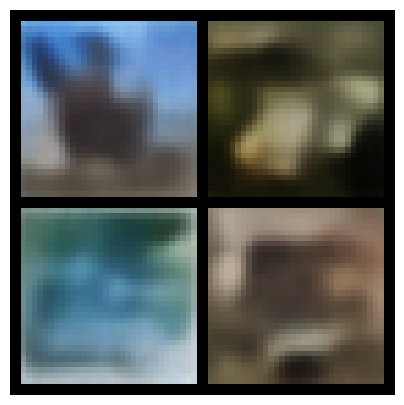

Epoch 23/50: 100%|██████████| 391/391 [00:23<00:00, 16.70it/s, Loss=1.58e+4]


Epoch [23/50] Average Loss: 183.7493


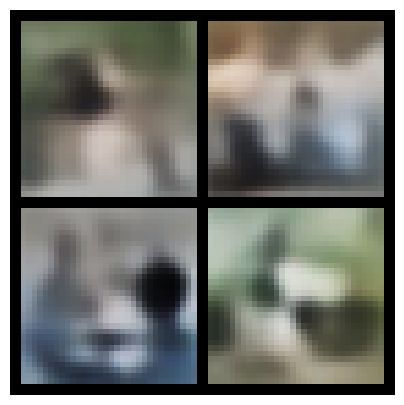

Epoch 24/50: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, Loss=1.45e+4]


Epoch [24/50] Average Loss: 183.5345


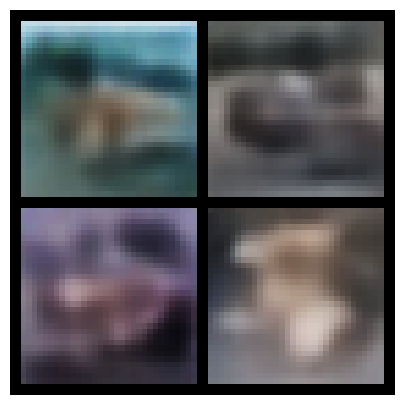

Epoch 25/50: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s, Loss=1.54e+4]


Epoch [25/50] Average Loss: 183.4125


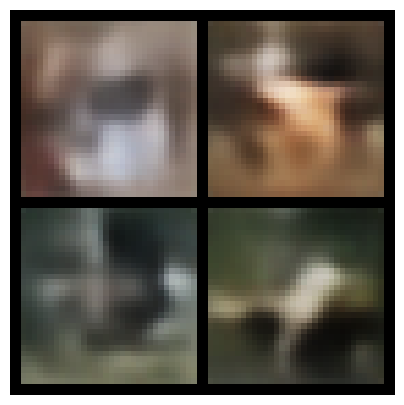

Epoch 26/50: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s, Loss=1.48e+4]


Epoch [26/50] Average Loss: 183.2106


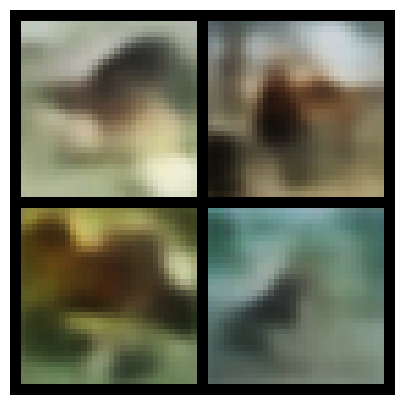

Epoch 27/50: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=1.39e+4]


Epoch [27/50] Average Loss: 183.0830


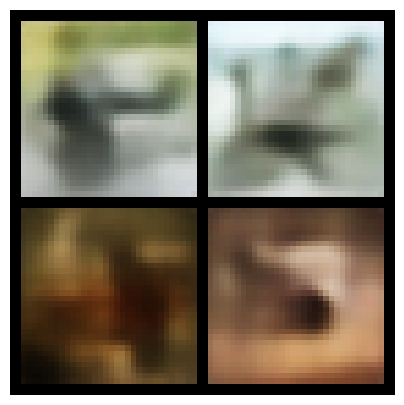

Epoch 28/50: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s, Loss=1.59e+4]


Epoch [28/50] Average Loss: 183.0187


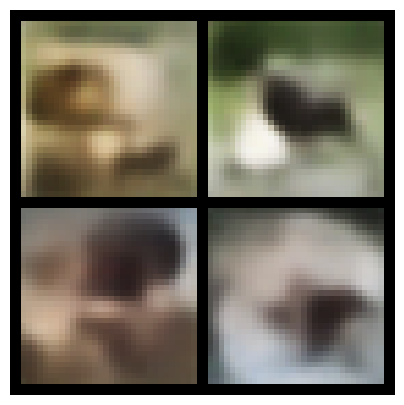

Epoch 29/50: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s, Loss=1.56e+4]


Epoch [29/50] Average Loss: 182.8000


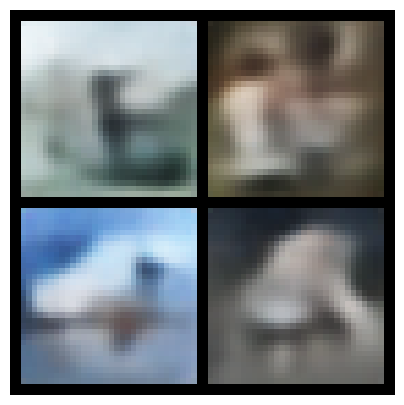

Epoch 30/50: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s, Loss=1.47e+4]


Epoch [30/50] Average Loss: 182.5768


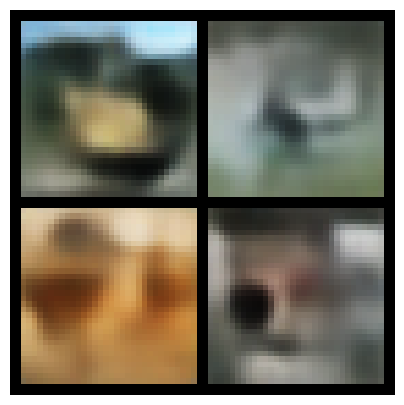

Epoch 31/50: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s, Loss=1.41e+4]


Epoch [31/50] Average Loss: 182.5247


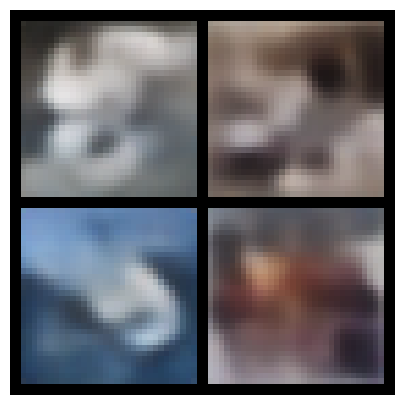

Epoch 32/50: 100%|██████████| 391/391 [00:23<00:00, 16.36it/s, Loss=1.39e+4]


Epoch [32/50] Average Loss: 182.3184


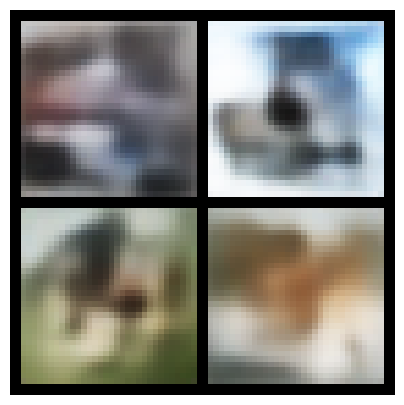

Epoch 33/50: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s, Loss=1.47e+4]


Epoch [33/50] Average Loss: 182.3024


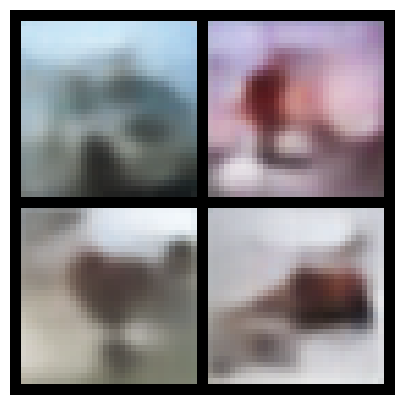

Epoch 34/50: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s, Loss=1.49e+4]


Epoch [34/50] Average Loss: 182.1386


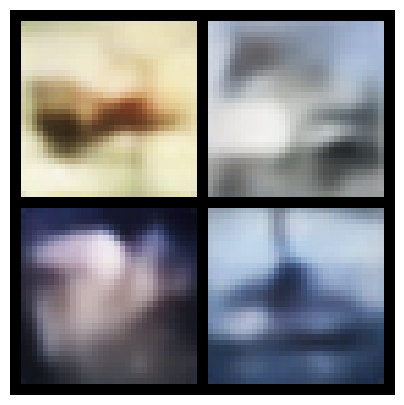

Epoch 35/50: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s, Loss=1.47e+4]


Epoch [35/50] Average Loss: 182.0065


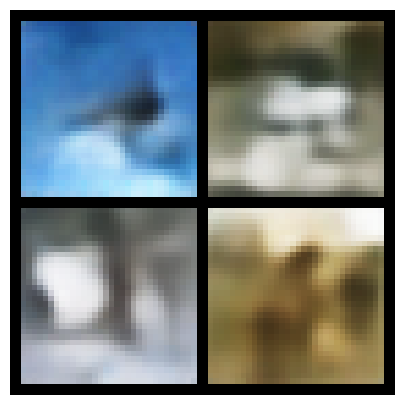

Epoch 36/50: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s, Loss=1.45e+4]


Epoch [36/50] Average Loss: 182.0114


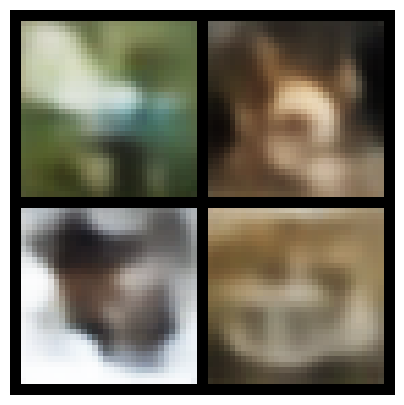

Epoch 37/50: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s, Loss=1.48e+4]


Epoch [37/50] Average Loss: 181.7223


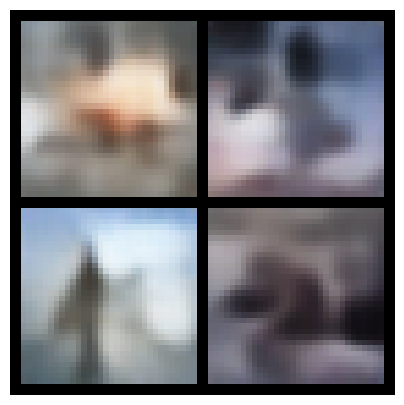

Epoch 38/50: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s, Loss=1.46e+4]


Epoch [38/50] Average Loss: 181.7653


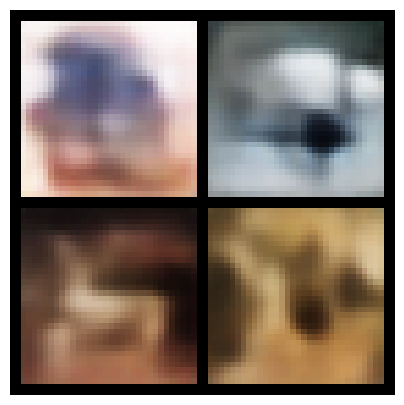

Epoch 39/50: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s, Loss=1.45e+4]


Epoch [39/50] Average Loss: 181.7274


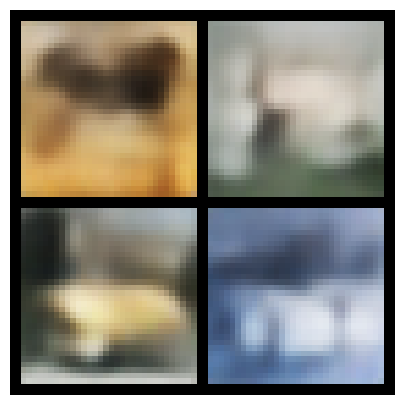

Epoch 40/50: 100%|██████████| 391/391 [00:24<00:00, 16.21it/s, Loss=1.46e+4]


Epoch [40/50] Average Loss: 181.4981


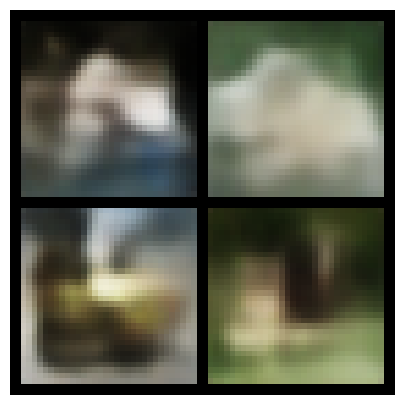

Epoch 41/50: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s, Loss=1.47e+4]


Epoch [41/50] Average Loss: 181.4815


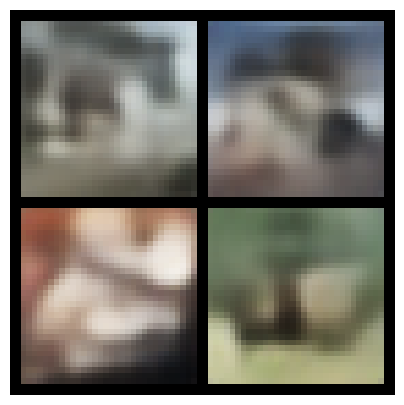

Epoch 42/50: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s, Loss=1.42e+4]


Epoch [42/50] Average Loss: 181.3235


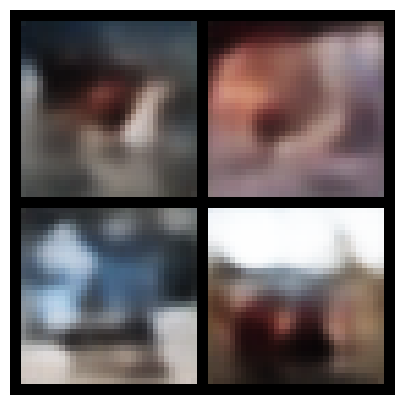

Epoch 43/50: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s, Loss=1.38e+4]


Epoch [43/50] Average Loss: 181.3542


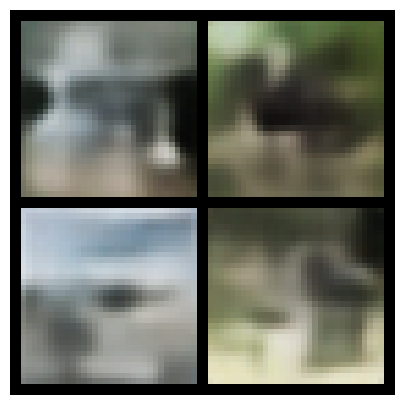

Epoch 44/50: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s, Loss=1.44e+4]


Epoch [44/50] Average Loss: 181.1861


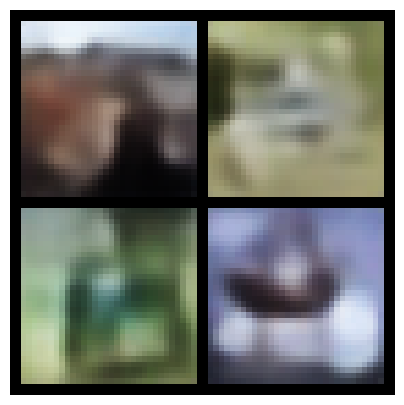

Epoch 45/50: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s, Loss=1.45e+4]


Epoch [45/50] Average Loss: 181.1728


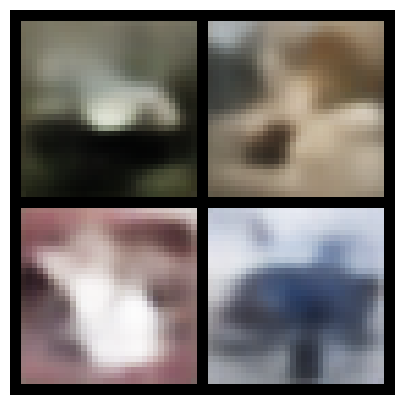

Epoch 46/50: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s, Loss=1.6e+4]


Epoch [46/50] Average Loss: 181.1259


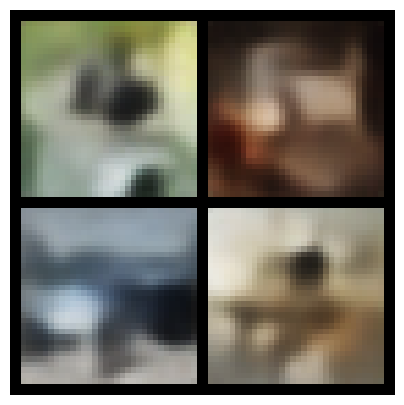

Epoch 47/50: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s, Loss=1.35e+4]


Epoch [47/50] Average Loss: 181.0493


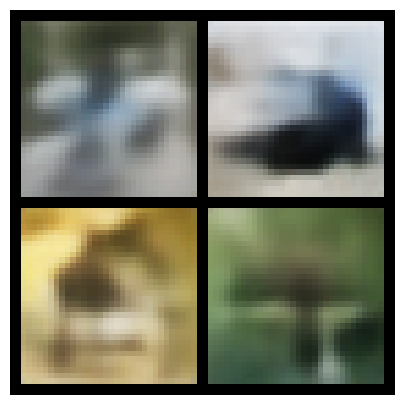

Epoch 48/50: 100%|██████████| 391/391 [00:24<00:00, 15.88it/s, Loss=1.41e+4]


Epoch [48/50] Average Loss: 180.9772


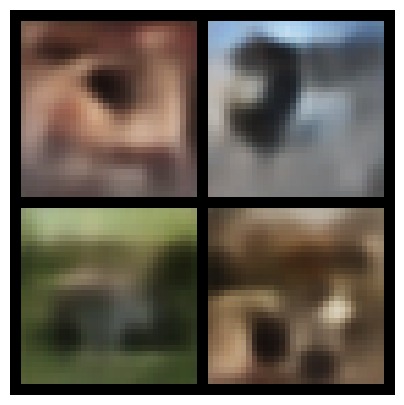

Epoch 49/50: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s, Loss=1.52e+4]


Epoch [49/50] Average Loss: 180.9112


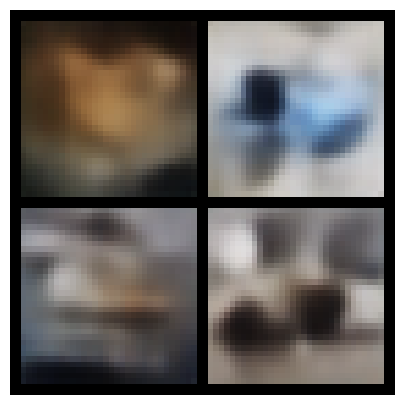

Epoch 50/50: 100%|██████████| 391/391 [00:24<00:00, 15.66it/s, Loss=1.54e+4]


Epoch [50/50] Average Loss: 180.8270


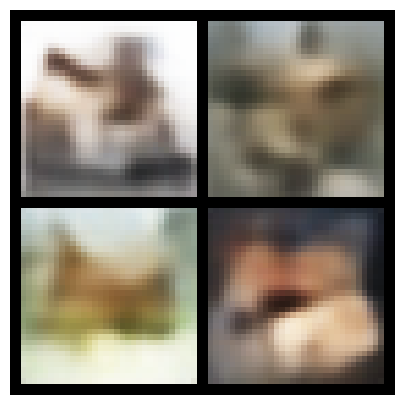

In [8]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    with torch.no_grad():
        sampled_images = model.sample(num_samples=4)
        show_image(sampled_images.cpu())

## Visualize the reconstructions

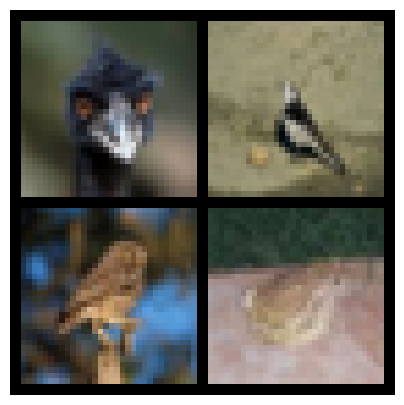

In [9]:
input_images, _ = next(iter(train_loader))
show_image(input_images)

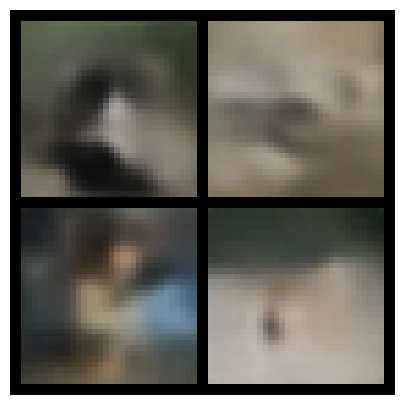

In [10]:
recons_images = model(input_images.to(device))[0]
show_image(recons_images.cpu())